**Assignment 2 , GNR 650**

**22m2152 , 22m2159**

In [1]:
# import requests

# url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1"
# response = requests.get(url)

# # Specify the path where you want to save the dataset
# filepath = "/home/cminds/CMInDS/Uddeshya/GNR650/Dataset"

# with open(filepath, 'wb') as file:
#     file.write(response.content)

In [3]:
# import zipfile

# with zipfile.ZipFile('/home/cminds/CMInDS/Uddeshya/GNR650/Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/cminds/CMInDS/Uddeshya/GNR650/data/Eurosat')


In [2]:
import os
import cv2
import numpy as np
def load_images_from_folder(folder_path):
    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more extensions if needed
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)

    return images

base_folder = "/home/cminds/CMInDS/Uddeshya/GNR650_GIT/GNR650/data/Eurosat/EuroSAT_RGB"
all_images = []

# Create a dictionary for folder (class) name to numeric label mapping
folder_names = [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))]
label_map = {folder_name: idx for idx, folder_name in enumerate(folder_names)}

# Iterate over all folders in the base directory
all_labels = []  # To store the labels corresponding to each image

# Iterate over all folders in the base directory
for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)
    if os.path.isdir(folder_path):  # Check if it's a directory
        images_in_folder = load_images_from_folder(folder_path)
        all_images.extend(images_in_folder)
        all_labels.extend([label_map[folder_name]] * len(images_in_folder))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [3]:
all_images.shape,all_labels.shape

((27000, 64, 64, 3), (27000,))

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (e.g., convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to the input size expected by ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = CustomImageDataset(all_images, all_labels, transform=transform)


In [5]:
import torch

SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [91]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # Use 80% of data for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [92]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle the test set


In [93]:
def count_images_per_label(dataset):
    label_counts = {}
    for _, label in dataset:
        label = label.item()  # Convert tensor to a Python integer, if it's a tensor
        label_counts[label] = label_counts.get(label, 0) + 1
    return label_counts

train_label_counts = count_images_per_label(train_dataset)
test_label_counts = count_images_per_label(test_dataset)


In [94]:
train_label_counts,test_label_counts

({0: 1988,
  7: 2013,
  1: 1592,
  6: 2416,
  3: 2002,
  9: 2420,
  2: 1992,
  5: 2409,
  8: 2377,
  4: 2391},
 {2: 508,
  0: 512,
  8: 623,
  4: 609,
  6: 584,
  5: 591,
  9: 580,
  7: 487,
  3: 498,
  1: 408})

In [95]:
# import matplotlib.pyplot as plt

# # Load the image
# image = plt.imread('/home/cminds/CMInDS/Uddeshya/GNR650/data/Eurosat/EuroSAT_RGB/AnnualCrop/AnnualCrop_1.jpg')

# # Print the shape of the image
# height, width, channels = image.shape
# print(f"Image dimensions: Width: {width}, Height: {height}")
# print(f"Number of channels: {channels}") # Typically 3 for RGB, 4 for RGBA


In [96]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
/bin/bash: /home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2


In [97]:
import torchinfo
from torchinfo import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [98]:
import torch
import timm
from torchsummary import summary

# Ensure you have a GPU for this, as the model can be large
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ViT-B/12 model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the final layer for 10 classes
model.head = torch.nn.Linear(model.head.in_features, 10)

model = model.to(device)

# Print the model summary
# Assuming input image size is 3x224x224 (channels x height x width)
#summary(model, input_size=(3, 224, 224))



In [99]:
import timm

# Load the ViT-B/12 model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Count the number of transformer blocks
num_blocks = len(model.blocks)

print(f"The ViT-B/12 model has {num_blocks} transformer blocks.")


The ViT-B/12 model has 12 transformer blocks.


In [100]:
# import torch
# import timm

# def prepare_vit_for_finetuning(layer_to_finetune='head'):
#     """
#     Prepare the ViT-B/12 model for fine-tuning on a specific layer.
    
#     Args:
#     - layer_to_finetune (str or tuple): Name of the layer to be fine-tuned or 
#                                         ('blocks', idx) for a specific transformer block.
    
#     Returns:
#     - model: Modified ViT model ready for fine-tuning.
#     """
    
#     # Load the ViT-B/12 model
#     model = timm.create_model('vit_base_patch16_224', pretrained=True)
    
#     # Set all layers to not require gradients
#     for param in model.parameters():
#         param.requires_grad = False
        
#     # If targeting a specific transformer block
#     if isinstance(layer_to_finetune, tuple) and layer_to_finetune[0] == 'blocks':
#         idx = layer_to_finetune[1]
#         for param in model.blocks[idx].parameters():
#             param.requires_grad = True
#     else:
#         # Enable gradients for the specified layer
#         for param in getattr(model, layer_to_finetune).parameters():
#             param.requires_grad = True
        
#         # Modify the final layer for 10 classes
#         if layer_to_finetune == 'head':
#             model.head = torch.nn.Linear(model.head.in_features, 10)
    
#     return model

# Example usage to fine-tune the 5th transformer block:




In [101]:
import torch
import timm

def prepare_vit_for_finetuning(mode='specific', blocks_to_unfreeze=[]):
    """
    Prepare the ViT-B/12 model for fine-tuning on specific blocks or all blocks or none.
    
    Args:
    - mode (str): One of 'specific', 'all', or 'none'.
    - blocks_to_unfreeze (list): List of block indices to be unfrozen (only used if mode='specific').
    
    Returns:
    - model: Modified ViT model ready for fine-tuning.
    """
    
    # Load the ViT-B/12 model
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    
    # Set all layers to not require gradients
    for param in model.parameters():
        param.requires_grad = False
    
    # Based on mode, adjust the requires_grad property
    if mode == 'specific':
        for idx in blocks_to_unfreeze:
            for param in model.blocks[idx].parameters():
                param.requires_grad = True
    elif mode == 'all':
        for param in model.parameters():
            param.requires_grad = True
    elif mode == 'none':
        pass  # already set all to not require gradients
    else:
        raise ValueError("Invalid mode. Choose from 'specific', 'all', or 'none'.")

    # Modify the final layer for 10 classes
    model.head = torch.nn.Linear(model.head.in_features, 10)
    
    return model



In [102]:
model_8_9_10_11 = prepare_vit_for_finetuning(mode='specific', blocks_to_unfreeze=[8,9,10,11]).to(device)
# model = model.to(device)


In [103]:
model_untrained = prepare_vit_for_finetuning(mode='all').to(device)
# model = model.to(device)


In [104]:
model_fully_trained = prepare_vit_for_finetuning(mode='none').to(device)
# model = model.to(device)


In [105]:
model_11 = prepare_vit_for_finetuning(mode='specific', blocks_to_unfreeze=[11]).to(device)

In [106]:
def check_learnable_blocks(model):
    """
    Print whether each block in the model has learnable parameters.

    Args:
    - model (torch.nn.Module): The PyTorch model to inspect.

    Returns:
    - None. Prints the learnability of each block.
    """
    
    block_learnability = {}  # Dictionary to store block learnability

    for name, param in model.named_parameters():
        if param.requires_grad:
            # Split the name to get the main block name
            split_name = name.split('.')
            block_name = split_name[1] if len(split_name) > 1 else split_name[0]
            block_learnability[block_name] = True

    print("Block learnability:")
    for block, learnable in block_learnability.items():
        if learnable:
            print(f"{block} is learnable")
        else:
            print(f"{block} is not learnable")


In [107]:
check_learnable_blocks(model_11)

Block learnability:
11 is learnable
weight is learnable
bias is learnable


In [108]:
check_learnable_blocks(model_8_9_10_11)

Block learnability:
8 is learnable
9 is learnable
10 is learnable
11 is learnable
weight is learnable
bias is learnable


In [109]:
check_learnable_blocks(model_untrained)

Block learnability:
cls_token is learnable
pos_embed is learnable
proj is learnable
0 is learnable
1 is learnable
2 is learnable
3 is learnable
4 is learnable
5 is learnable
6 is learnable
7 is learnable
8 is learnable
9 is learnable
10 is learnable
11 is learnable
weight is learnable
bias is learnable


In [110]:
check_learnable_blocks(model_fully_trained)

Block learnability:
weight is learnable
bias is learnable


In [111]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, num_epochs, device):
    """
    Train the model using the provided data.

    Args:
    - model (torch.nn.Module): The model to train.
    - train_loader (DataLoader): DataLoader for the training data.
    - num_epochs (int): Number of epochs to train.
    - device (torch.device): Device to which the model and data should be moved before training.

    Returns:
    - model: Trained model.
    """

    criterion = nn.CrossEntropyLoss()  # Define the loss function
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # Only optimize unfrozen parameters

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()  # Zero out any gradient accumulation
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:  # Print loss every 10 batches
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    return model


In [112]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model's performance on the provided data.

    Args:
    - model (torch.nn.Module): The model to evaluate.
    - test_loader (DataLoader): DataLoader for the test data.
    - device (torch.device): Device to which the model and data should be moved before evaluation.

    Returns:
    - accuracy (float): Model's accuracy on the test data.
    """

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on test data: {accuracy:.2f}%")
    return accuracy


In [113]:
def main():
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = 3 # You can adjust this

    # Train the model
    model1 = train_model(model_11, train_loader, num_epochs, device)
    model2 = train_model(model_8_9_10_11, train_loader, num_epochs, device)
    model3 = train_model(model_untrained, train_loader, num_epochs, device)
    model4 = train_model(model_fully_trained, train_loader, num_epochs, device)

    # Evaluate the model on test data
    evaluate_model(model1, test_loader, device)
    evaluate_model(model2, test_loader, device)
    evaluate_model(model3, test_loader, device)
    evaluate_model(model4, test_loader, device)

# Call the main function to execute the training and testing process
main()


Epoch 1/3, Batch 0/675, Loss: 2.4282
Epoch 1/3, Batch 50/675, Loss: 0.1379
Epoch 1/3, Batch 100/675, Loss: 0.0930
Epoch 1/3, Batch 150/675, Loss: 0.0638
Epoch 1/3, Batch 200/675, Loss: 0.1269
Epoch 1/3, Batch 250/675, Loss: 0.0797
Epoch 1/3, Batch 300/675, Loss: 0.0935
Epoch 1/3, Batch 350/675, Loss: 0.0358
Epoch 1/3, Batch 400/675, Loss: 0.0738
Epoch 1/3, Batch 450/675, Loss: 0.1972
Epoch 1/3, Batch 500/675, Loss: 0.0252
Epoch 1/3, Batch 550/675, Loss: 0.0938
Epoch 1/3, Batch 600/675, Loss: 0.0884
Epoch 1/3, Batch 650/675, Loss: 0.0557
Epoch 2/3, Batch 0/675, Loss: 0.0243
Epoch 2/3, Batch 50/675, Loss: 0.1041
Epoch 2/3, Batch 100/675, Loss: 0.1799
Epoch 2/3, Batch 150/675, Loss: 0.0018
Epoch 2/3, Batch 200/675, Loss: 0.0059
Epoch 2/3, Batch 250/675, Loss: 0.0265
Epoch 2/3, Batch 300/675, Loss: 0.0057
Epoch 2/3, Batch 350/675, Loss: 0.0206
Epoch 2/3, Batch 400/675, Loss: 0.0363
Epoch 2/3, Batch 450/675, Loss: 0.0015
Epoch 2/3, Batch 500/675, Loss: 0.0039
Epoch 2/3, Batch 550/675, Loss:

In [115]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [116]:
def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

In [117]:
def visualize_attention_layers(network, train_loader, inv_transforms, img_size=(224, 224), device='cuda'):
    """
    Visualize attention maps across different layers of the ViT model.
    
    Args:
    - network (torch.nn.Module): The Vision Transformer model.
    - train_loader (DataLoader): DataLoader for the training data.
    - inv_transforms (function): Function to inverse the transformations applied to the image.
    - img_size (tuple): Size of the image. Default is (224, 224).
    - device (str): Device to run the model on. Default is 'cuda'.
    """
    
    imgs, _ = next(iter(train_loader))
    img = imgs[0]
    num_blocks = len(network.blocks)
    fig, axes = plt.subplots(nrows=num_blocks, ncols=3, figsize=(6, 24))
    
    # Set column labels (titles)
    axes[0][0].set_title('Original Image')
    axes[0][1].set_title('Attention Map')
    axes[0][2].set_title('Overlayed Image')
    
    if img.ndim != 4:
        img = img.unsqueeze(0)

    display_img = inv_transforms(img).detach()[0]
    display_img = torch.permute(display_img, (1, 2, 0))
    img = img.to(device)
    
    for i in range(num_blocks):
        network.blocks[i].attn.forward = my_forward_wrapper(network.blocks[i].attn)
        output = network(img)
        
        cls_weight = network.blocks[i].attn.cls_attn_map.mean(dim=1).detach().cpu()
        # In order to make 14x14 patch and then resize to 224x224
        zero = torch.tensor([[0.]])
        cls_weight = torch.cat([cls_weight, zero], dim=1).view(14, 14)
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), img_size, mode='bilinear').view(*img_size, 1)

        axes[i][0].imshow(display_img)
        axes[i][0].set_ylabel(f'Attn. Head {i}')
        axes[i][0].yaxis.label.set(rotation='horizontal', ha='right')
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])
        axes[i][1].imshow(cls_resized, cmap='inferno')
        axes[i][1].axis('off')
        axes[i][2].imshow(display_img)
        axes[i][2].imshow(cls_resized, alpha=0.6)
        axes[i][2].axis('off')
    
    plt.tight_layout()  # To ensure proper spacing between subplots
    plt.show()


In [118]:
def visualize_attention_main(model):
    # Load and prepare the model for fine-tuning the last transformer block
    # model = prepare_vit_for_finetuning(('blocks', 11))  # 11 for the last block (0-based indexing)
    # model = model.to(device)
    
    # Define inverse transformations for visualization. Adjust as per your transformations.
    inv_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                         std=[1/0.229, 1/0.224, 1/0.225]),
    ])
    
    # Call the visualization function
    visualize_attention_layers(model, train_loader, inv_transforms)

# Call the main function for visualization


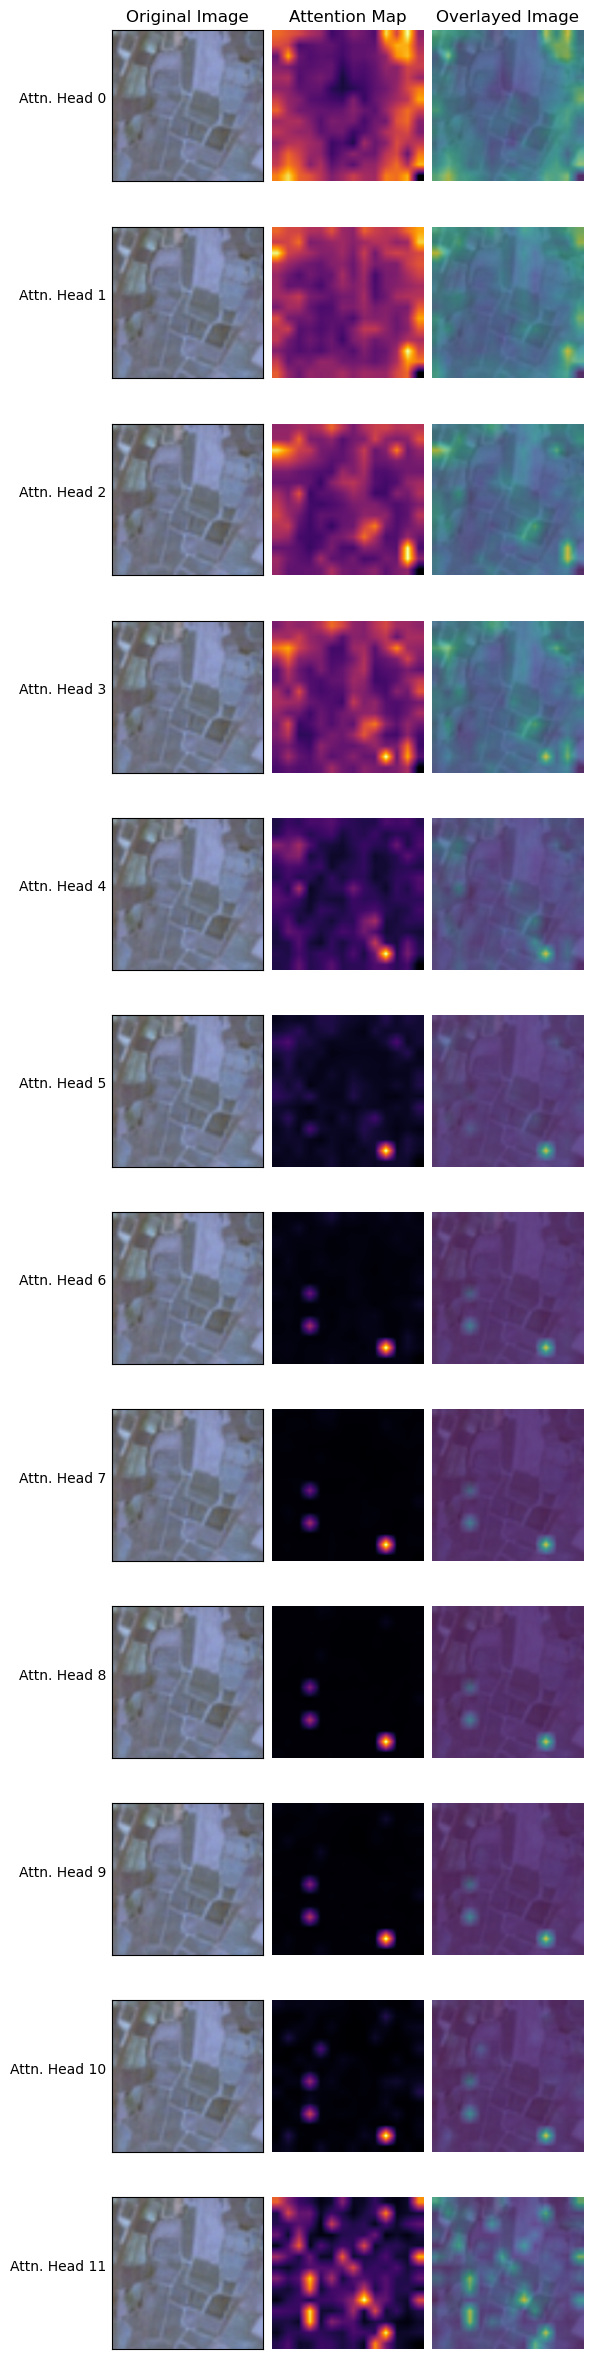

In [119]:
visualize_attention_main(model_11)

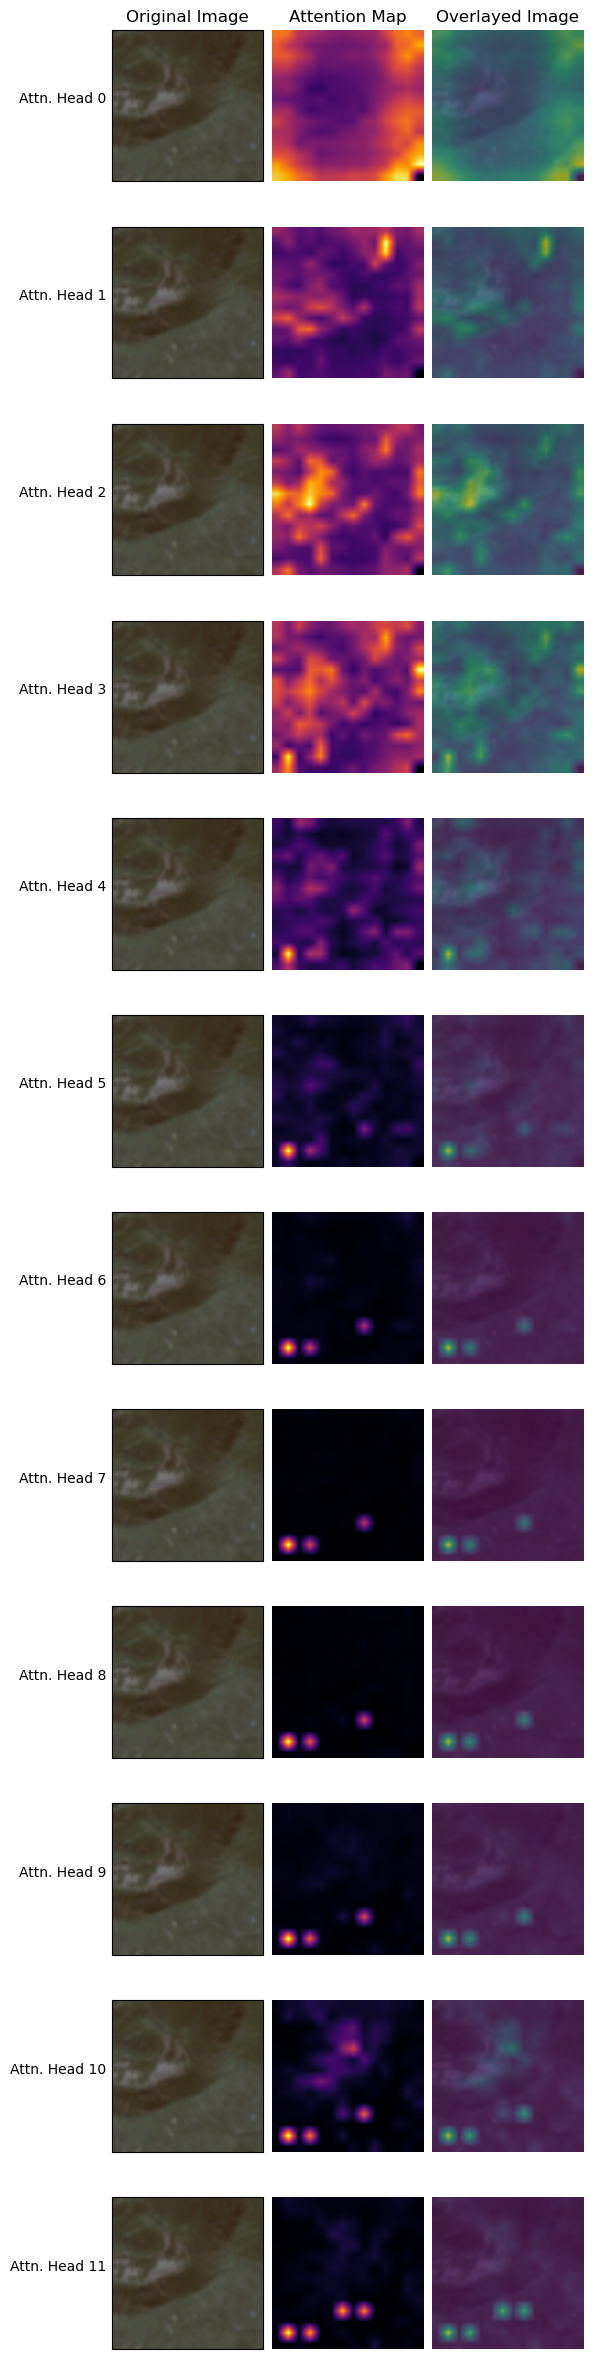

In [120]:
visualize_attention_main(model_8_9_10_11)

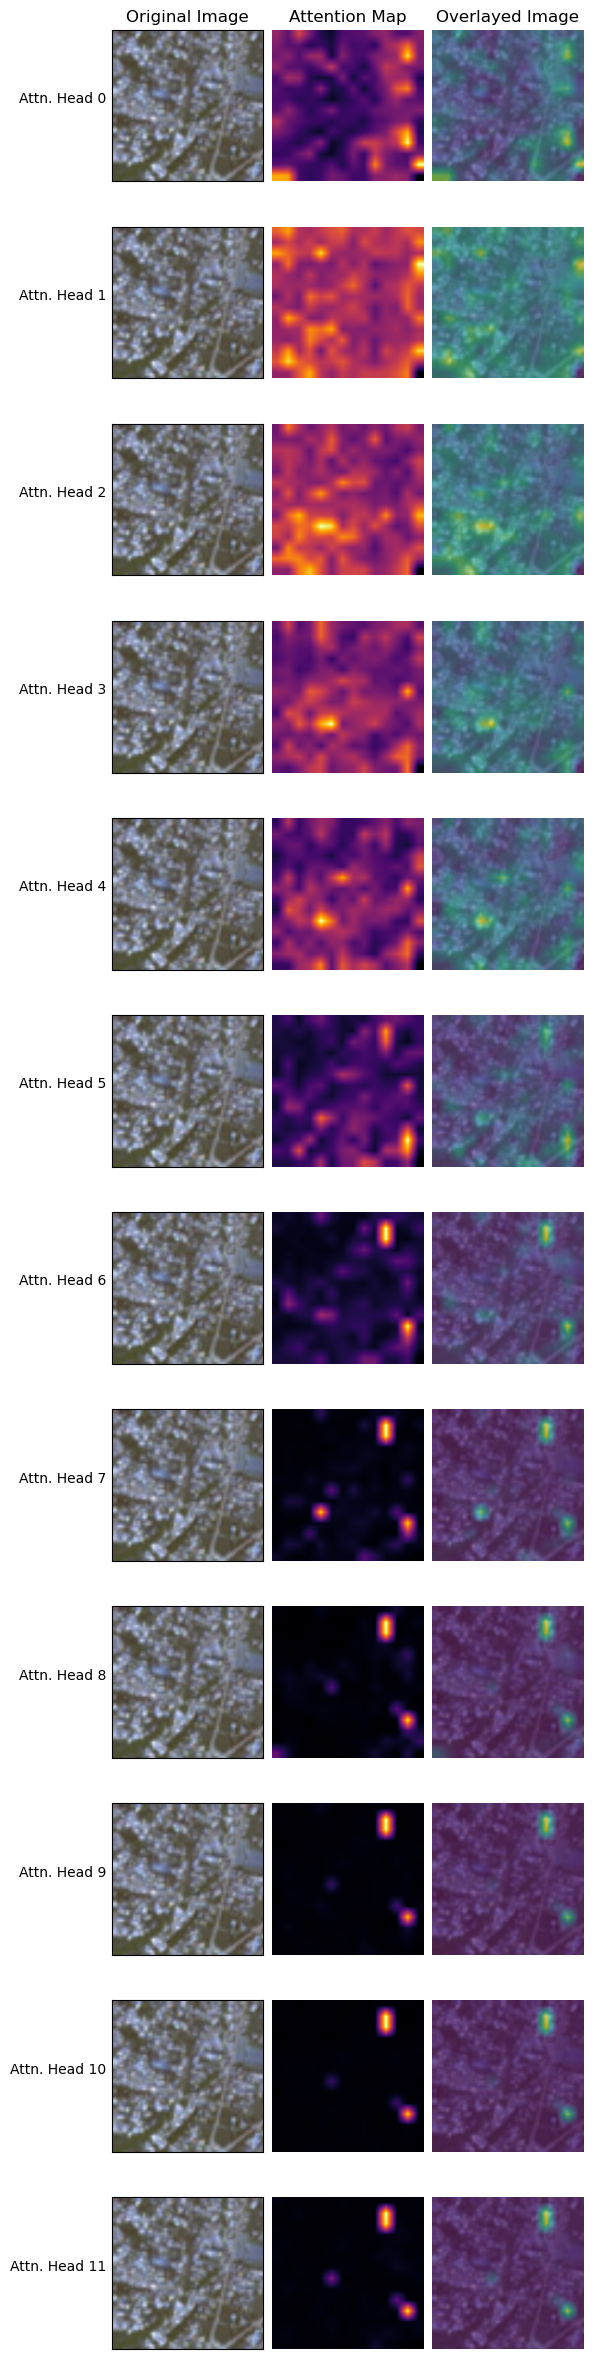

In [121]:
visualize_attention_main(model_untrained)

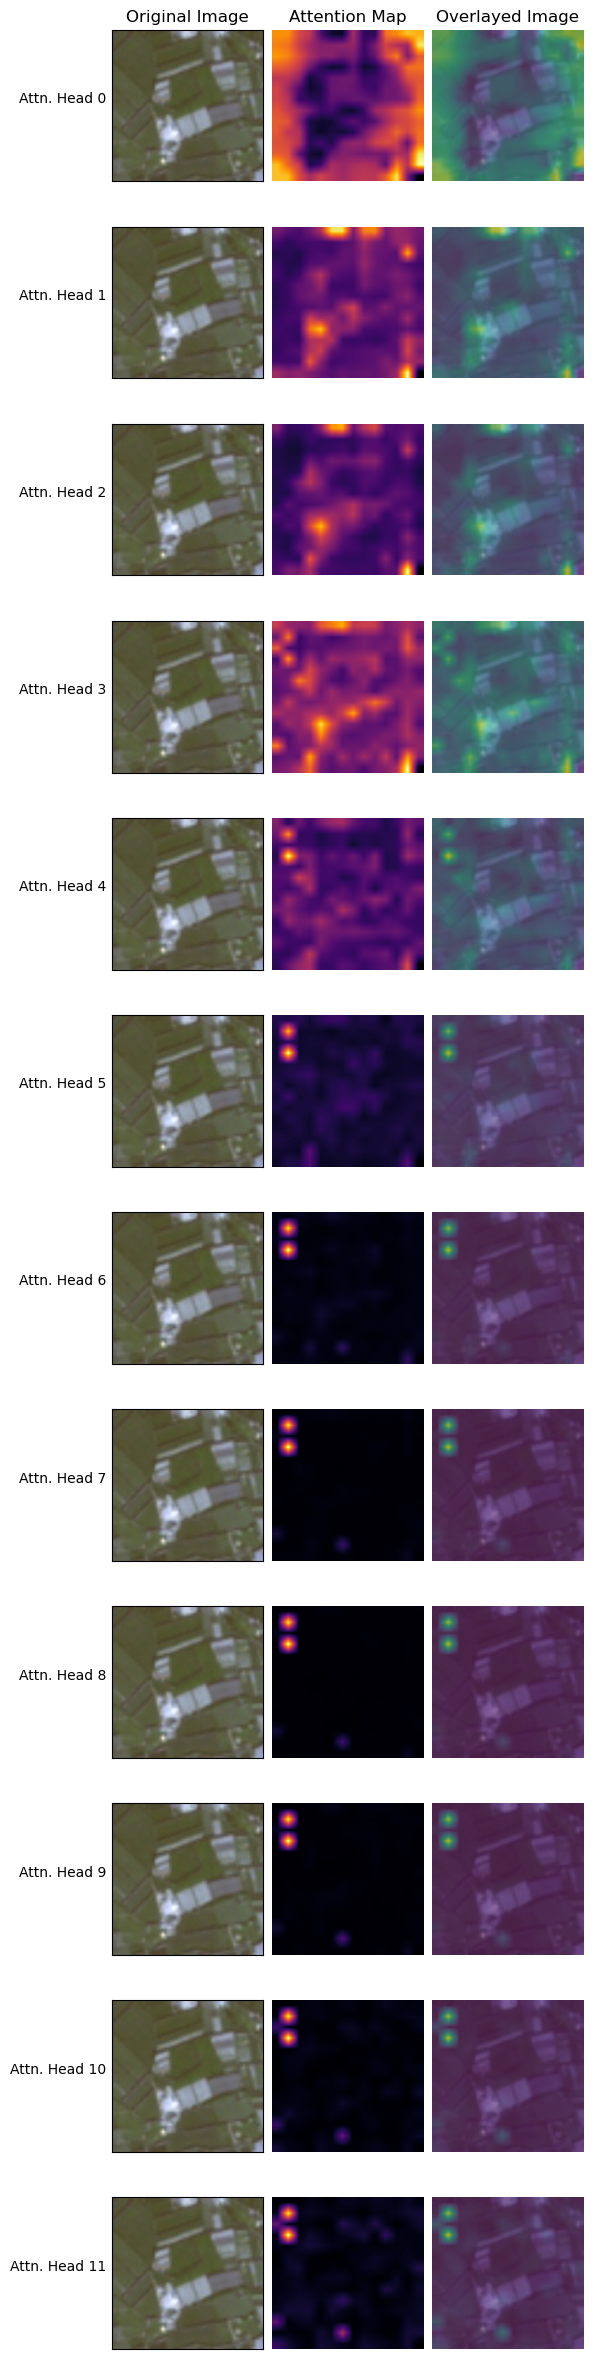

In [122]:
visualize_attention_main(model_fully_trained)